In [13]:
from matplotlib import pyplot as plt
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
import wandb
from wandb.keras import WandbCallback

mnist_num_classes = 10 
mnist_image_size = 784

(mnist_training_images, mnist_training_labels), (mnist_test_images, mnist_test_labels) = mnist.load_data()
mnist_training_data = mnist_training_images.reshape(mnist_training_images.shape[0], mnist_image_size) 
mnist_test_data = mnist_test_images.reshape(mnist_test_images.shape[0], mnist_image_size)

mnist_training_labels = to_categorical(mnist_training_labels, mnist_num_classes)
mnist_test_labels = to_categorical(mnist_test_labels, mnist_num_classes)

In [10]:
# A helpful function we'll be using all over the place to plot training information:
def plot_training_history(history, model):
    figure = plt.figure()

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['training', 'validation'], loc='best')
    plt.tight_layout()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['training', 'validation'], loc='best')
    plt.tight_layout()

    figure.tight_layout()
    plt.tight_layout()
    plt.show()
    
    loss, accuracy  = model.evaluate(mnist_test_data, mnist_test_labels, verbose=False)

    print(f'Test loss: {loss:.3}')
    print(f'Test accuracy: {accuracy:.3}')

In [5]:
# It's also worth considering dropout only at specific layers
# not just at every layer. The complexity that builds up near
# the end of a network holds a greater risk of contributing to 
# overfitting. Experiment with that too:
def model_with_selective_dropout(dropout_rate, dropout_layers):
    assert dropout_layers <= 5
    
    model = Sequential()
    model.add(Dense(units=64, activation='relu', input_shape=(mnist_image_size,)))
    
    no_drop_layers = 5 - dropout_layers
    for _ in range(no_drop_layers):
        model.add(Dense(units=64, activation='relu'))
        
    for _ in range(dropout_layers):
        model.add(Dense(units=64, activation='relu'))
        model.add(Dropout(rate=dropout_rate))

    model.add(Dense(units=mnist_num_classes, activation='softmax'))
    
    return model


In [ ]:
# There are lots of parameters you can set here, including the amount that counts as a change
# what metric to watch, and more. See the documentation for more details. We'll keep it
# simple for now, and use the defaults for most of these. 
early_stopper = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

wandb.init(
    project="SelectiveOptWandB",
    job_type="training"
) # Initializes wandb

config = wandb.config # Config is a variable that holds and saves hyperparameters and inputs
config.dropout = 0.2
config.dropout_layers = 3
config.batch_size = 32
config.validation_split = 0.2
config.hidden_layer_size = 128
config.epochs = 25

# Note, we didn't get far with .8 or .5, so I removed them for this experiment
# However, in larger networks .8 and .5 may be reasonable choices! Don't over
# generalize the findings that might be specific to this network architecture 
# and this dataset!
dropout_rates = [.3, .2, .1]
dropout_layers = [3, 2, 1]


# Now, lets repeat the same experiment we just did, but with early stopping!
model = model_with_selective_dropout(config.dropout, config.dropout_layers) 
model.compile(optimizer='nadam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(mnist_training_data,
                    mnist_training_labels,
                    batch_size=config.batch_size,
                    epochs=config.epochs,
                    verbose=True,
                    validation_split=config.validation_split,
                    callbacks=[early_stopper, WandbCallback])

model.save("dnn.h5")
plot_training_history(history, model)


Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


CommError: argument of type 'NoneType' is not iterable

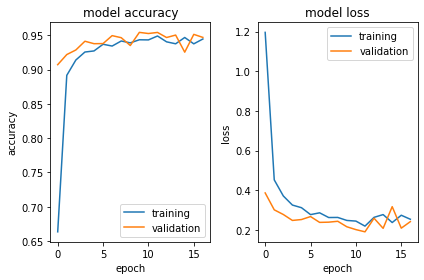

Test loss: 0.19
Test accuracy: 0.954


In [11]:
plot_training_history(history, model)